# Анализ данных в задаче кредитного скоринга

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportion_confint
import scipy
from scipy.stats import chi2_contingency
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Загружаем и изучаем данные

In [2]:
df = pd.read_csv('credit_card_default_analysis.csv', sep=',')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

* LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)
*SEX: пол клиента (1 = мужской, 2 = женский)
*EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных )
*MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных)
*AGE: возраст в годах
*PAY_0 - PAY_6 : История прошлых платежей по кредиту
*PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
*BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
*PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
*default - индикатор невозврата денежных средств (вернул кредит default = 0, не вернул default = 1)


## Размер кредитного лимита (LIMIT_BAL).

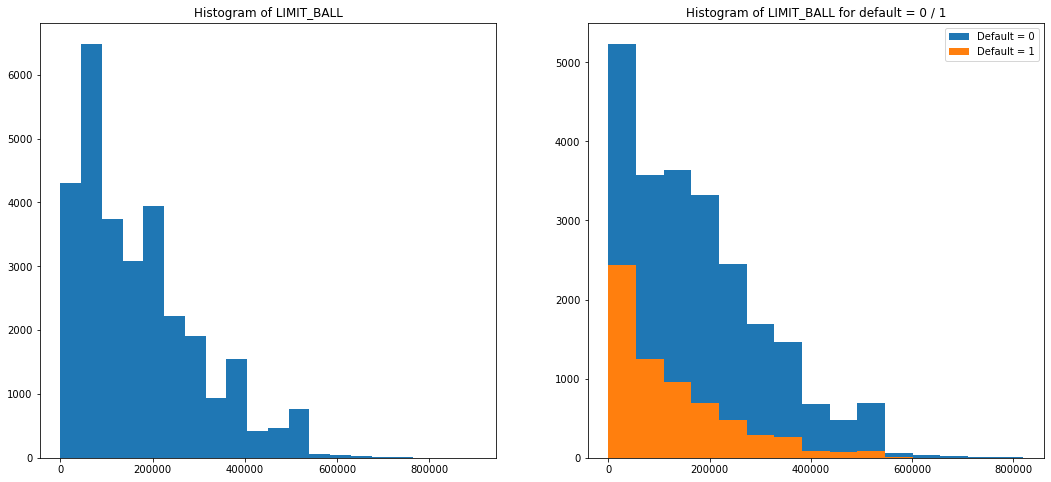

In [4]:
plt.figure(1, figsize=(18,8))
plt.subplot(121)
plt.title('Histogram of LIMIT_BALL')
plt.hist(df['LIMIT_BAL'], bins=20, range=(0,900000))

plt.subplot(122)
plt.title('Histogram of LIMIT_BALL for default = 0 / 1')
plt.hist(df.LIMIT_BAL.loc[df.default == 0], label='Default = 0', bins=15, range=(0,820000))
plt.hist(df.LIMIT_BAL.loc[df.default == 1], label='Default = 1', bins=15, range=(0,820000))
plt.legend()

Гистограммы возвращеных и не возвращенных кредитов по форме похожи. Крупные кредиты не возвращают реже чем мелкие.

### a) В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверяю гипотезу  о равенстве медианных значений кредитного лимита с помощью интервальной оценки. 
Распределение оличается от нормального, поэтому для интервальной оценки буду применять  bootstrap.

$H_0:$ медианные значения равны

$H_1:$ медианные значения отличаются

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [6]:
limit_bal_0 = df[df.default == 0].LIMIT_BAL.values
limit_bal_1 = df[df.default == 1].LIMIT_BAL.values


In [7]:
limit_bal_0_scores = list(map(np.median, get_bootstrap_samples(limit_bal_0, 1000)))
limit_bal_1_scores = list(map(np.median, get_bootstrap_samples(limit_bal_1, 1000)))
print('95% довери́тельный интерва́л медианы кредитного лимита вернувших кредит:', stat_intervals(limit_bal_0_scores, 0.05))
print('95% довери́тельный интерва́л медианы кредитного лимита не вернувших кредит:', stat_intervals(limit_bal_1_scores, 0.05))

95% довери́тельный интерва́л медианы кредитного лимита вернувших кредит: [150000. 150000.]
95% довери́тельный интерва́л медианы кредитного лимита не вернувших кредит: [80000. 90000.]


In [8]:
#Точечная оценка разности медиан

print("разность медиан:", np.median(limit_bal_0) - np.median(limit_bal_1))

разность медиан: 60000.0


In [9]:
#Интервальная оценка разности медиан
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(limit_bal_0_scores, limit_bal_1_scores)))
print("95% довери́тельный интерва́л для разности медиан",  stat_intervals(delta_median_scores, 0.05))

95% довери́тельный интерва́л для разности медиан [60000. 70000.]


Из интервальной оценки видно медианы не совпадают. Нулевая гипотеза отвергается на уровне значимости 0.05. Размер эффекта большой.  Думаю этот результат имеет практическую значимость. 

### b) В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверяю гипотезу о равенстве распределений кредитного лимита с помощью перестановочного критерия.

$H_0\colon F_{X_0}(x) = F_{X_1}(x)$

$H_1\colon F_{X_0}(x) = F_{X_1}(x + \Delta), \Delta\neq 0$

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [11]:
print("p-value: %f" % permutation_test(limit_bal_0, limit_bal_1, max_permutations = 1000))

p-value: 0.001000


Нулевая гипотеза отвергается на уровне значимости 0.05. Размер эффекта большой.  Думаю этот результат имеет практическую значимость.

## Пол (SEX): Проверяю гендерный состав  группы людей вернувших и не вернувших кредит . 

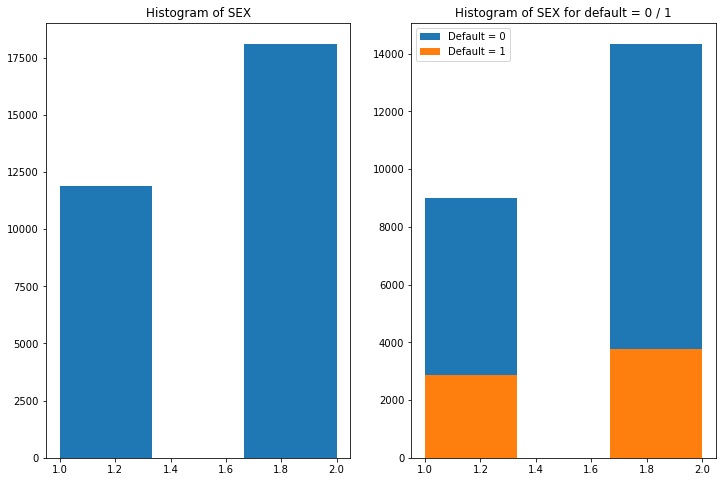

In [12]:
plt.figure(1, figsize=(12,8))
plt.subplot(121)
plt.title('Histogram of SEX')
plt.hist(df['SEX'], bins=3)

plt.subplot(122)

plt.title('Histogram of SEX for default = 0 / 1')
plt.hist(df.SEX.loc[df.default == 0], label='Default = 0', bins=3)
plt.hist(df.SEX.loc[df.default == 1], label='Default = 1', bins=3)
plt.legend()


$H_0\colon p_0 = p_1$

$H_1\colon p_0 > p_1$

Использую интервальную оценку долей

In [13]:
sex_0 = df[df.default == 0].SEX.values - 1
sex_1 = df[df.default == 1].SEX.values - 1


In [14]:
print('95% довери́тельный интерва́л гендерного состава вернувших кредит:', proportion_confint(sum(sex_0), 
                                            len(sex_0), method = 'wilson'))
print('95% довери́тельный интерва́л гендерного состава не вернувших кредит:', proportion_confint(sum(sex_1), 
                                            len(sex_1), method = 'wilson'))

95% довери́тельный интерва́л гендерного состава вернувших кредит: (0.607889734030124, 0.6203726841910749)
95% довери́тельный интерва́л гендерного состава не вернувших кредит: (0.5551017630282817, 0.578937581965066)


Использую Z-критерий для разности долей (независимые выборки)

In [15]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [16]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [17]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [18]:
print("95%% довери́тельный интерва́л для разницы гендерного состава вернувших кредит и не вернувших кредит: [%f, %f]" %\
      proportions_diff_confint_ind(sex_0, sex_1))

95% довери́тельный интерва́л для разницы гендерного состава вернувших кредит и не вернувших кредит: [0.033635, 0.060548]


In [19]:
print("p-value: %.15f" % proportions_diff_z_test(proportions_diff_z_stat_ind(sex_0, sex_1)))

p-value: 0.000000000004473


In [20]:
print("p-value: %.15f" % proportions_diff_z_test(proportions_diff_z_stat_ind(sex_0, sex_1), 'greater'))

p-value: 0.000000000002236


Нулевая гипотеза отвергается на уровне значимости 0.05. Гендерный состав  группы людей вернувших и не вернувших кредит отличается. Женщины чаще возвращают кредит. Размер эффекта  значитильный.  Думаю этот результат  имеет практическую значимость.

## Образование (EDUCATION): 
EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных )

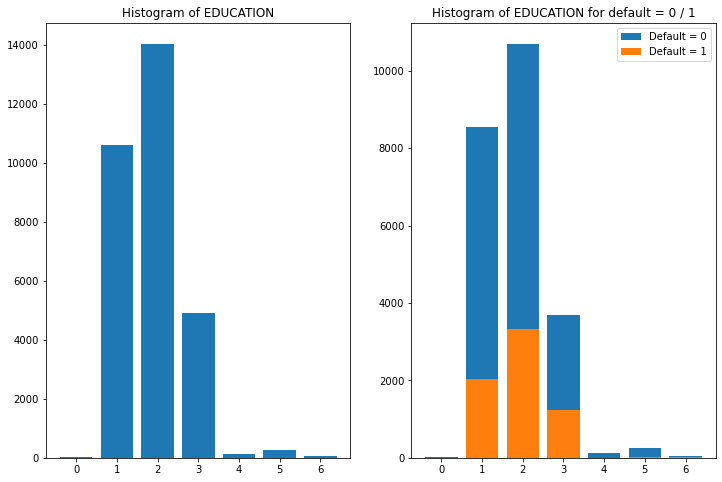

In [21]:
plt.figure(1, figsize=(12,8))
plt.subplot(121)
plt.title('Histogram of EDUCATION')
#plt.hist(df['EDUCATION'], bins=15)
plt.bar(df.groupby(['EDUCATION']).count().index, df.groupby(['EDUCATION']).count().ID)
plt.subplot(122)

plt.title('Histogram of EDUCATION for default = 0 / 1')
plt.bar(df.groupby(['EDUCATION']).count().index, df.loc[df.default == 0].groupby(['EDUCATION']).count().ID, label='Default = 0')
plt.bar(df.loc[df.default == 1].groupby(['EDUCATION']).count().index, df.loc[df.default == 1].groupby(['EDUCATION']).count().ID, label='Default = 1')
#plt.hist(df.EDUCATION.loc[df.default == 0], label='Default = 0', bins=15)
#plt.hist(df.EDUCATION.loc[df.default == 1], label='Default = 1', bins=15)
plt.legend()

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг.

In [22]:
df_edu = df.pivot_table('ID',index='EDUCATION', columns='default', aggfunc='count', fill_value=0)


In [23]:
df_edu.columns =['0', '1']
df_edu.head(7)

,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [24]:
df_edu['sum'] = df_edu['0'] + df_edu['1']
df_edu.head(7)


,0,1,sum
EDUCATION,,,
0,14,0,14
1,8549,2036,10585
2,10700,3330,14030
3,3680,1237,4917
4,116,7,123
5,262,18,280
6,43,8,51


In [25]:
df_edu['return_prop'] = df_edu['0'] / df_edu['sum']
df_edu.head(7)

,0,1,sum,return_prop
EDUCATION,,,,
0,14,0,14,1.000000
1,8549,2036,10585,0.807652
2,10700,3330,14030,0.762651
3,3680,1237,4917,0.748424
4,116,7,123,0.943089
5,262,18,280,0.935714
6,43,8,51,0.843137


<BarContainer object of 7 artists>

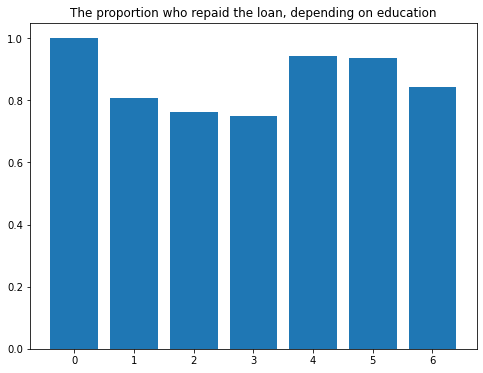

In [26]:
plt.figure(1, figsize=(8,6))
plt.title('The proportion who repaid the loan, depending on education')
plt.bar(df_edu.index, df_edu.return_prop)

Видно, что распределние не является равномерным, следовательно, образование влияет на то, вернёт ли человек долг. Доктора всегда возвращают кредиты, а также люди с начальным образованием чаще всего "отдают долги".

$H_0: X_1 и X_2 - независимы$

$H_1: H_0 - не верна$

Проверим гипотезу с помощью коэффициента V Крамера

In [27]:
edu_cont = df_edu[['0', '1']].values


In [28]:
def v_cramer(matrix): 
    chi2 = chi2_contingency(matrix)
    n = np.sum(matrix) 
    return np.sqrt(chi2[0] / (n*(min(matrix.shape)-1))), chi2[1] 

In [29]:
print( 'Kоэффициента V Крамера : %.5f, p-value: %e' %v_cramer(edu_cont))


Kоэффициента V Крамера : 0.07376, p-value: 1.233263e-32


Гипотеза о том, что образование не влияет на то, вернет ли человек долг отвергнута. Думаю этот результат  имеет практическую значимость.

## Семейное положение (MARRIAGE)
MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 

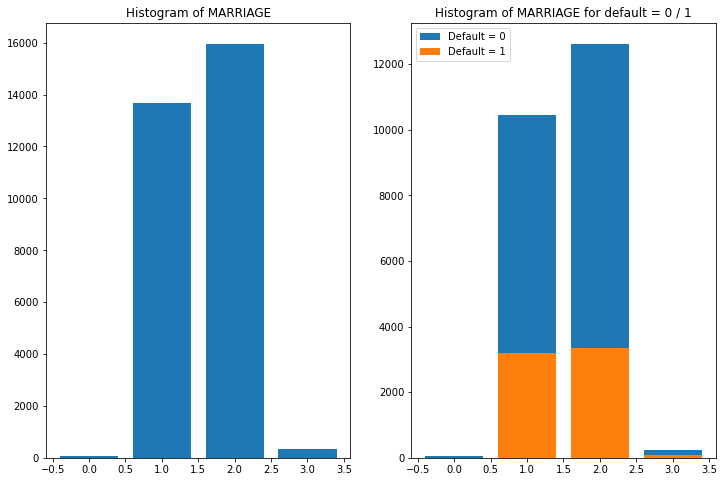

In [30]:
plt.figure(1, figsize=(12,8))
plt.subplot(121)
plt.title('Histogram of MARRIAGE')
plt.bar(df.groupby(['MARRIAGE']).count().index, df.groupby(['MARRIAGE']).count().ID)

plt.subplot(122)
plt.title('Histogram of MARRIAGE for default = 0 / 1')
plt.bar(df.groupby(['MARRIAGE']).count().index, df.loc[df.default == 0].groupby(['MARRIAGE']).count().ID, label='Default = 0')
plt.bar(df.loc[df.default == 1].groupby(['MARRIAGE']).count().index, df.loc[df.default == 1].groupby(['MARRIAGE']).count().ID, label='Default = 1')
#plt.hist(df.EDUCATION.loc[df.default == 0], label='Default = 0', bins=15)
#plt.hist(df.EDUCATION.loc[df.default == 1], label='Default = 1', bins=15)
plt.legend()

In [31]:
df_marr = df.pivot_table('ID',index='MARRIAGE', columns='default', aggfunc='count', fill_value=0)
df_marr.columns =['0', '1']
df_marr.head()

,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [32]:
df_marr['sum'] = df_marr['0'] + df_marr['1']
df_marr['return_prop'] = df_marr['0'] / df_marr['sum']
df_marr.head(7)

,0,1,sum,return_prop
MARRIAGE,,,,
0,49,5,54,0.907407
1,10453,3206,13659,0.765283
2,12623,3341,15964,0.790717
3,239,84,323,0.739938


<BarContainer object of 4 artists>

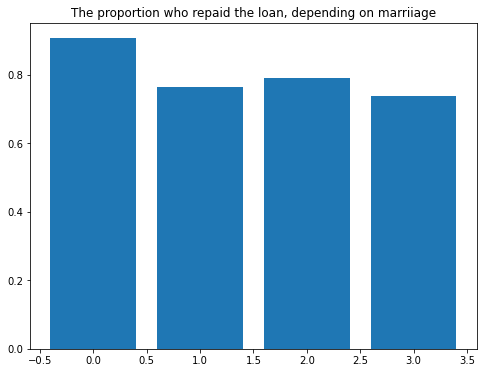

In [33]:
plt.figure(1, figsize=(8,6))
plt.title('The proportion who repaid the loan, depending on marriiage')
plt.bar(df_marr.index, df_marr.return_prop)

$H_0: X_1 и X_2 - независимы$

$H_1: H_0 - не верна$

Проверим гипотезу с помощью коэффициента V Крамера

In [34]:
edu_marr = df_marr[['0', '1']].values
print( 'Kоэффициента V Крамера : %.5f, p-value: %e' %v_cramer(edu_marr))

Kоэффициента V Крамера : 0.03448, p-value: 8.825862e-08


Гипотеза о том, что cемейное положение не влияет на то, вернет ли человек долг отвергнута. Коэффициент Крамера принимает значение, близкое к нулю,  практическая значимость мала.

## Возраст (AGE)
AGE: возраст в годах

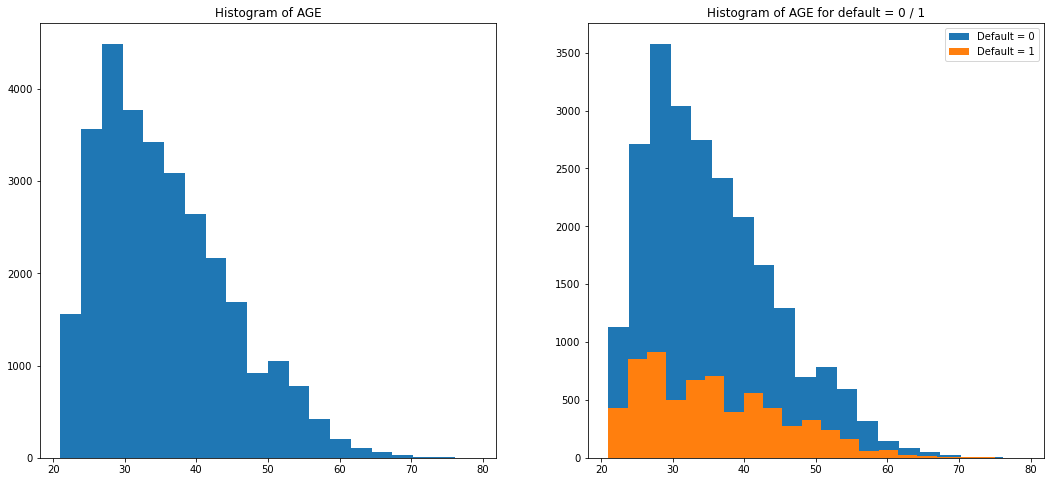

In [35]:
plt.figure(1, figsize=(18,8))
plt.subplot(121)
plt.title('Histogram of AGE')
plt.hist(df['AGE'], bins=20)

plt.subplot(122)
plt.title('Histogram of AGE for default = 0 / 1')
plt.hist(df.AGE.loc[df.default == 0], label='Default = 0', bins=20)
plt.hist(df.AGE.loc[df.default == 1], label='Default = 1', bins=20)
plt.legend()

### a) В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверяю гипотезу  о равенстве медианных значений возрастов людей с помощью интервальной оценки. 
Распределение оличается от нормального, поэтому для интервальной оценки буду применять  bootstrap.

$H_0:$ медианные значения равны

$H_1:$ медианные значения отличаются

In [36]:
age_0 = df[df.default == 0].AGE.values
age_1 = df[df.default == 1].AGE.values


In [37]:
age_0_scores = list(map(np.median, get_bootstrap_samples(age_0, 2000)))
age_1_scores = list(map(np.median, get_bootstrap_samples(age_1, 2000)))
print('95% довери́тельный интерва́л медианы возрастов людей вернувших кредит:', stat_intervals(age_0_scores, 0.05))
print('95% довери́тельный интерва́л медианы возрастов людей не вернувших кредит:', stat_intervals(age_1_scores, 0.05))

95% довери́тельный интерва́л медианы возрастов людей вернувших кредит: [34. 34.]
95% довери́тельный интерва́л медианы возрастов людей не вернувших кредит: [34. 35.]


In [38]:
#Точечная оценка разности медиан

print("разность медиан:", np.median(age_0) - np.median(age_1))

разность медиан: 0.0


In [39]:
#Интервальная оценка разности медиан
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(age_0_scores, age_1_scores)))
print("95% довери́тельный интерва́л для разности медиан",  stat_intervals(delta_median_scores, 0.05))

95% довери́тельный интерва́л для разности медиан [-1.  0.]


Доверительный интервал содержит ноль.Следовательно медианы совпадают. Нулевая гипотеза не отвергается на уровне значимости 0.05. Практическая значимость мала.

### b) В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверяю гипотезу о равенстве распределений возрастов людей с помощью перестановочного критерия.

$H_0\colon F_{X_0}(x) = F_{X_1}(x)$

$H_1\colon F_{X_0}(x) = F_{X_1}(x + \Delta), \Delta\neq 0$

In [40]:
print("p-value: %f" % permutation_test(age_0, age_1, max_permutations = 1000))

p-value: 0.017000


P-value мало, следовательно нулевая гипотеза отвергается на уровне значимости 0.05. Практическая значимость мала.